In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
data_path = '../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
SU2CLC2             SU2CLC2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
MGH                     MGH\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
SU2CLC1            SU2CLC1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [3]:
cohorts = pd.Series(cohorts).map(size).to_list()

## loading bechmarks

In [4]:
from glob import glob
csvs = glob('./baseline_run/LOCO_42/LOCO_*/source_performance.tsv')

res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    res.append(df)

data1 = pd.concat(res)
data1['cohort'] = data1.test_cohort.map(size)
data1.head()

,NR,R,0,1,train_cohort,test_cohort,best_C,mode,cohort
Index,,,,,,,,,
Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.415568,0.584432,Leave_Choueiri_out,Choueiri,0.1,CAF,Choueiri\n(n=16)
Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.431285,0.568715,Leave_Choueiri_out,Choueiri,0.1,CAF,Choueiri\n(n=16)
Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.527305,0.472695,Leave_Choueiri_out,Choueiri,0.1,CAF,Choueiri\n(n=16)
Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.569460,0.430540,Leave_Choueiri_out,Choueiri,0.1,CAF,Choueiri\n(n=16)
Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.427672,0.572328,Leave_Choueiri_out,Choueiri,0.1,CAF,Choueiri\n(n=16)


## loading conceptor

In [30]:
csvs = glob('./conceptor_run/LOCO_a100/LOCO_*/source_performance.tsv')
res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    res.append(df)

data2 = pd.concat(res)
data2['cohort'] = data2.test_cohort.map(size)
data2.head()

,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer,cohort
Index,,,,,,,,,,,,,
Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.946471,0.053529,Leave_Choueiri_out,Choueiri,49,1019029,FFT,24,64.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.975558,0.024442,Leave_Choueiri_out,Choueiri,49,1019029,FFT,24,64.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.033310,0.966690,Leave_Choueiri_out,Choueiri,49,1019029,FFT,24,64.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.999583,0.000417,Leave_Choueiri_out,Choueiri,49,1019029,FFT,24,64.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.039701,0.960299,Leave_Choueiri_out,Choueiri,49,1019029,FFT,24,64.0,[16],Choueiri\n(n=16)


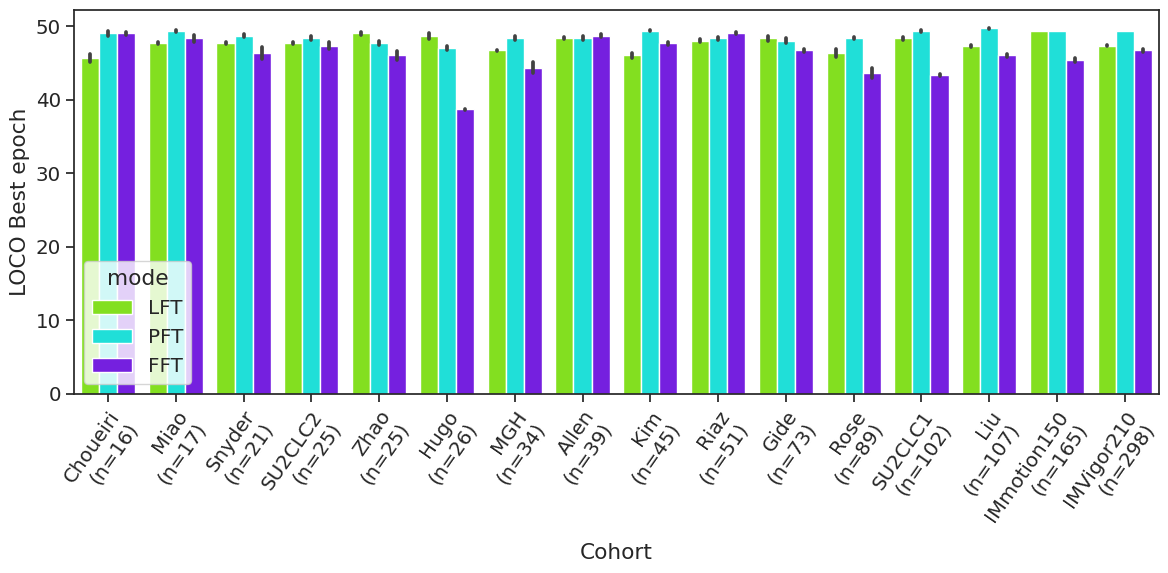

In [31]:
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

fig,ax = plt.subplots(figsize=(12,6))

palette = sns.palettes.color_palette('hsv', 3)

sns.barplot(data = data2, x = 'cohort', y = 'best_epoch', hue = 'mode', order = cohorts, 
            hue_order = ['LFT', 'PFT', 'FFT'], palette = palette,  ax=ax)

# sns.swarmplot(data = data,  x = 'cohort', y = 'best_epoch', hue = 'mode', order = cohorts,size=1,
#               palette = palette, alpha = 1, hue_order = ['NFT','LFT', 'PFT', 'FFT'],  edgecolor='k')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax.set_xticklabels(
    cohorts, 
    rotation=55, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Cohort')
ax.set_ylabel('LOCO Best epoch')
# ax.set_ylim(0,1)


fancybox1 = mpatches.FancyBboxPatch(xy = [0, -2.5], width = 4,height =  1, 
                                   boxstyle=mpatches.BoxStyle("square", pad=1), 
                                   facecolor='blue',  # 设置框的填充颜色为蓝色 edgecolor='red'
                                   )
fancybox2 = mpatches.FancyBboxPatch(xy = [6, -2.5], width = 4, height =  1, 
                                   boxstyle=mpatches.BoxStyle("square", pad=1), 
                                   facecolor='green',  # 设置框的填充颜色为蓝色 edgecolor='red'
                                   )
fancybox3 = mpatches.FancyBboxPatch(xy = [12, -2.5], width = 3,height =  1, 
                                   boxstyle=mpatches.BoxStyle("square", pad=1), 
                                   facecolor='red',  # 设置框的填充颜色为蓝色 edgecolor='red'
                                   )

ax.add_patch(fancybox1)
ax.add_patch(fancybox2)
ax.add_patch(fancybox3)

fig.tight_layout()

fig.savefig('./epochs_distribution.pdf')

In [32]:
data2 = data2.reset_index().groupby(['mode', 'train_cohort', 'test_cohort', 'cohort', 'Index'])[['NR', 'R', '0', '1']].mean().reset_index().set_index('Index')

## Merge & analysis

In [33]:
data = data2._append(data1)
data = data.reset_index()
data.head()

,Index,mode,train_cohort,test_cohort,cohort,NR,R,0,1,best_C
0,MEL-IPI_Pat02-Tumor-SM-4DJZX,FFT,Leave_Allen_out,Allen,Allen\n(n=39),0.0,1.0,0.982421,0.017579,NaN
1,MEL-IPI_Pat03-Tumor-SM-4DJZY,FFT,Leave_Allen_out,Allen,Allen\n(n=39),1.0,0.0,0.999720,0.000280,NaN
2,MEL-IPI_Pat04-Tumor-SM-4DJZZ,FFT,Leave_Allen_out,Allen,Allen\n(n=39),0.0,1.0,0.083040,0.916960,NaN
3,MEL-IPI_Pat06-Tumor-SM-4DK12,FFT,Leave_Allen_out,Allen,Allen\n(n=39),1.0,0.0,0.436256,0.563744,NaN
4,MEL-IPI_Pat08-Tumor-SM-4DK14,FFT,Leave_Allen_out,Allen,Allen\n(n=39),1.0,0.0,0.211735,0.788265,NaN


In [34]:
dfp = data.groupby(['cohort', 'mode']).apply(lambda x: score2(x['R'], x['1'],
                                                             x[['0', '1']].idxmax(axis=1).astype(int)))
dfp = dfp.apply(pd.Series)
dfp.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfp = dfp.reset_index()
dfp['size'] = dfp.cohort.apply(lambda x:x.split('n=')[-1].replace(')', ''))
dfp['size'] = dfp['size'].astype(int)
def cohort_size(x):
    if x <= 30:
       s = 'small'
    elif 100 > x > 30:
        s = 'medium'
    elif x > 100:
        s = 'large'
    return s
dfp['size_map'] = dfp['size'].map(cohort_size)
dfp.head()

,cohort,mode,ROC,PRC,F1,ACC,MCC,size,size_map
0,Allen\n(n=39),CAF,0.458580,0.303469,0.342857,0.410256,-0.146254,39,medium
1,Allen\n(n=39),CD8,0.636095,0.426006,0.466667,0.589744,0.146254,39,medium
2,Allen\n(n=39),CIS,0.674556,0.434426,0.551724,0.666667,0.294884,39,medium
3,Allen\n(n=39),CKS,0.662722,0.437393,0.482759,0.615385,0.184302,39,medium
4,Allen\n(n=39),CTL,0.671598,0.501632,0.482759,0.615385,0.184302,39,medium


In [35]:
dfp.groupby(['size_map', 'cohort']).size()

size_map  cohort              
large     IMVigor210\n(n=298)     26
          IMmotion150\n(n=165)    26
          Liu\n(n=107)            26
          SU2CLC1\n(n=102)        26
medium    Allen\n(n=39)           26
          Gide\n(n=73)            26
          Kim\n(n=45)             26
          MGH\n(n=34)             26
          Riaz\n(n=51)            26
          Rose\n(n=89)            26
small     Choueiri\n(n=16)        26
          Hugo\n(n=26)            26
          Miao\n(n=17)            26
          SU2CLC2\n(n=25)         26
          Snyder\n(n=21)          26
          Zhao\n(n=25)            26
dtype: int64

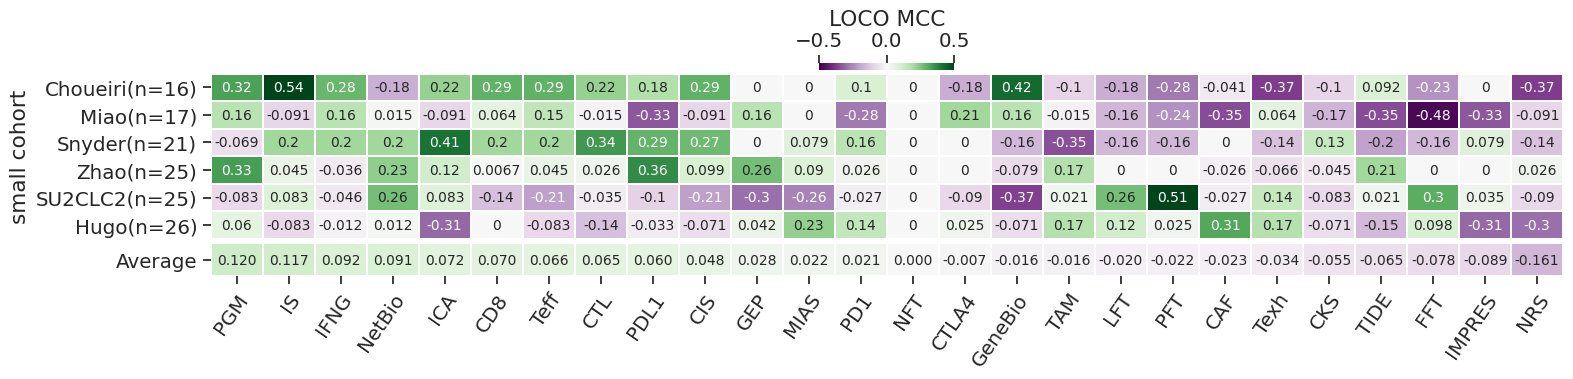

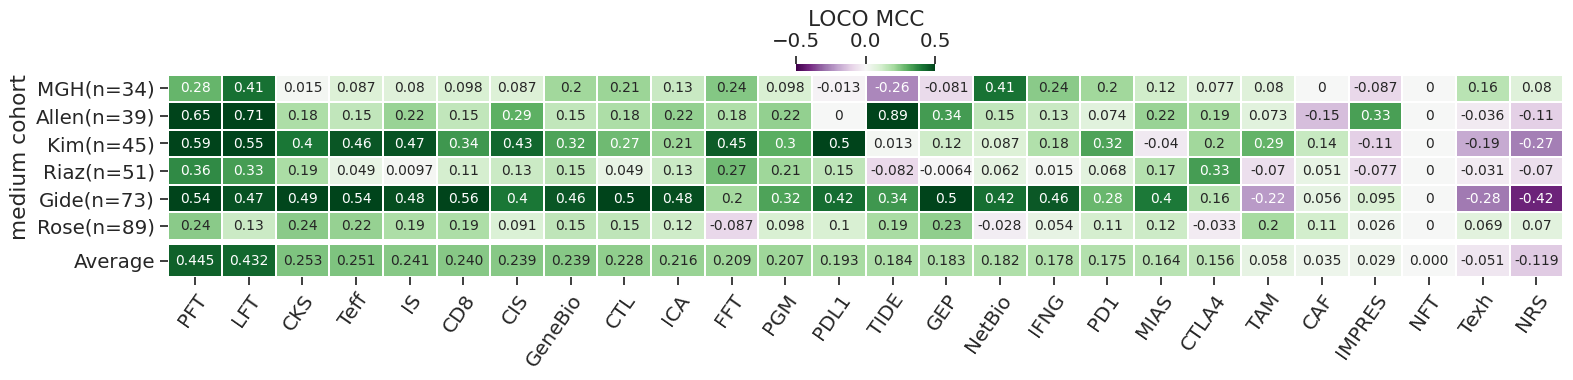

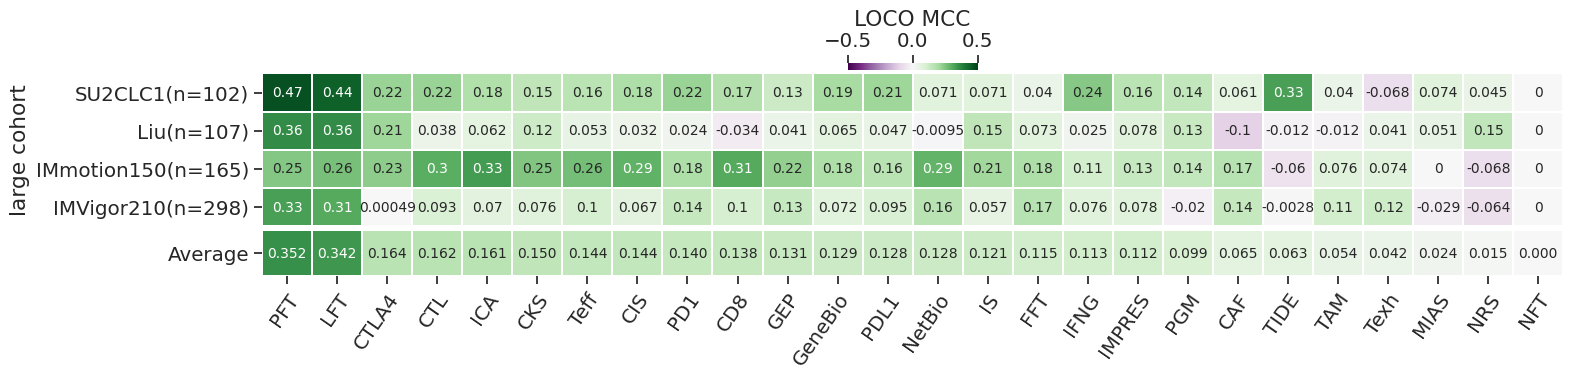

In [36]:
values = 'MCC'
    
cmap = 'PRGn'
vmax = 0.5
vmin = -0.5

for s in ['small', 'medium', 'large']:

    dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))
    
    y_order = dfp1.sort_values('size')['cohort_name'].unique()
    data2d = pd.pivot_table(dfp1, index='mode', columns = 'cohort_name', values = values)
    modes = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    data2d = data2d[y_order]
    data2d = data2d.loc[modes].T

    
    fig,axes = plt.subplots(figsize=(16, 4), nrows=2, height_ratios = [len(y_order), 1], sharex=True)
    ax1, ax2 = axes  

    cbar_kws=dict(location="top",pad=0.02,shrink=0.1, label = 'LOCO %s' % values)
    sns.heatmap(data2d, cmap = cmap, vmax = vmax, vmin = vmin, ax=ax1, cbar_kws = cbar_kws,
                    linewidths = 0.1, annot=True, annot_kws = {'fontsize':10})
    
    
    sns.heatmap(data2d.mean().to_frame(name='Average').T, 
                
                cmap = cmap, vmax = vmax, vmin = vmin,
                ax=ax2, annot=True, linewidths=.1,fmt='.3f',
                 annot_kws={"fontsize":10}, cbar=False)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('%s cohort' % s)
        
    ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax2.set_xticklabels(
        modes, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke
    
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)
    ax2.set_xlabel('')
    
    fig.tight_layout(h_pad = 0.2)
    fig.savefig('./%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )

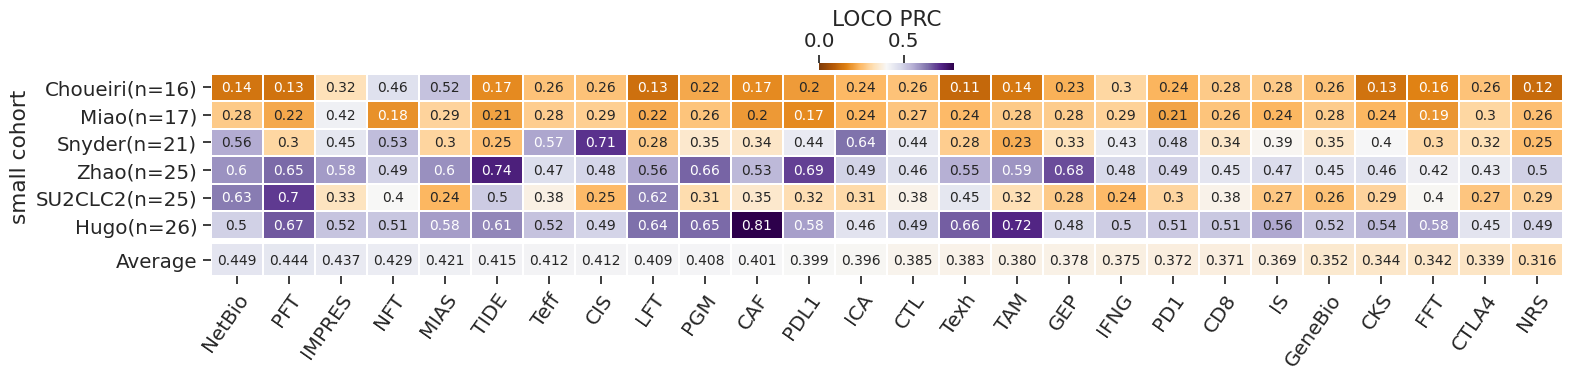

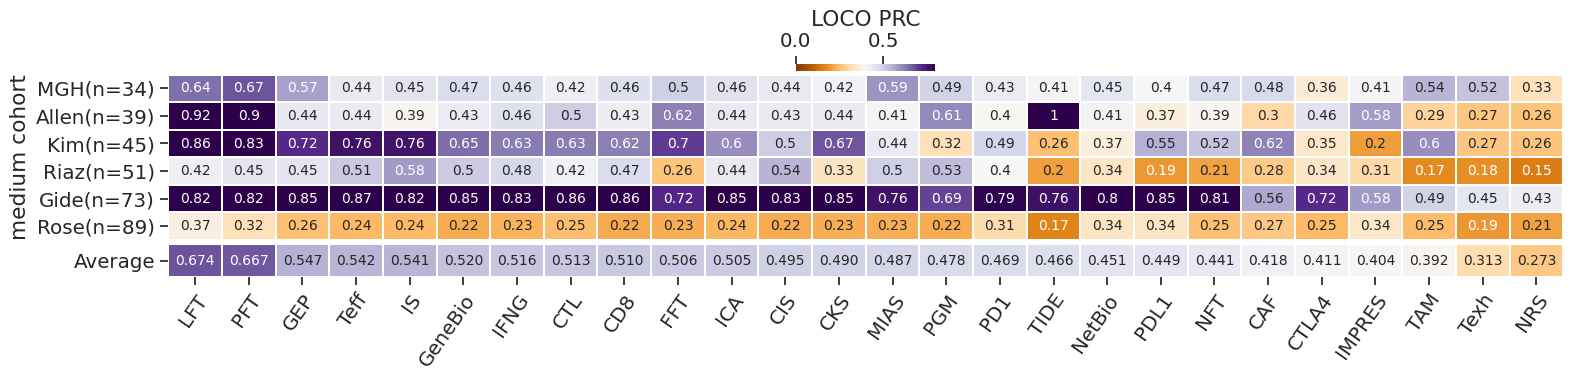

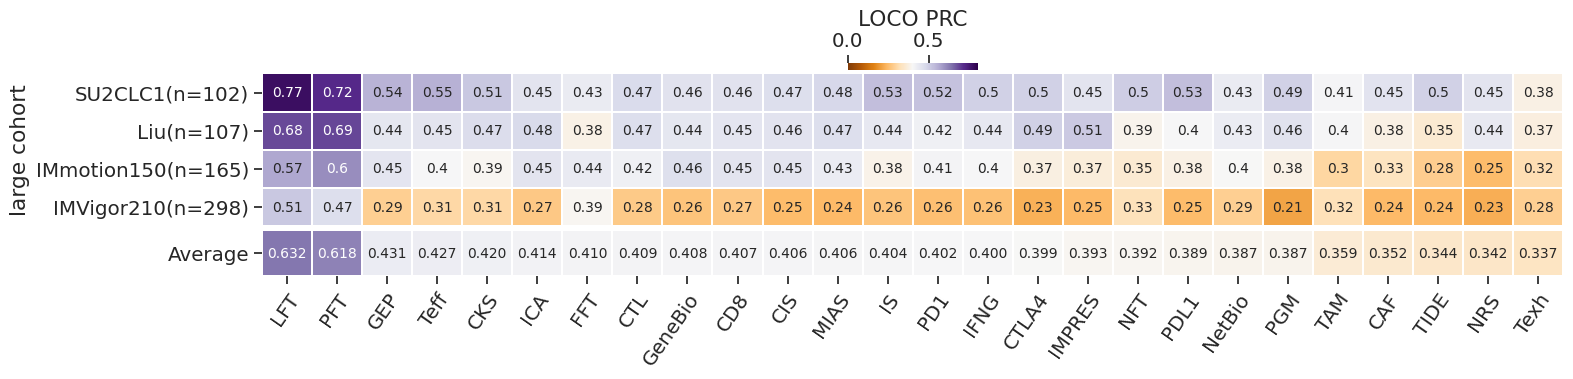

In [37]:
values = 'PRC'
    
cmap = 'PuOr' #PRGn PuOr
vmax = 0.8
vmin = 0.0

for s in ['small', 'medium', 'large']:

    dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))
    
    y_order = dfp1.sort_values('size')['cohort_name'].unique()
    data2d = pd.pivot_table(dfp1, index='mode', columns = 'cohort_name', values = values)
    modes = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    data2d = data2d[y_order]
    data2d = data2d.loc[modes].T

    
    fig,axes = plt.subplots(figsize=(16, 4), nrows=2, height_ratios = [len(y_order), 1], sharex=True)
    ax1, ax2 = axes  

    cbar_kws=dict(location="top",pad=0.02,shrink=0.1, label = 'LOCO %s' % values)
    sns.heatmap(data2d, cmap = cmap, vmax = vmax, vmin = vmin, ax=ax1, cbar_kws = cbar_kws,
                    linewidths = 0.1, annot=True, annot_kws = {'fontsize':10})
    
    
    sns.heatmap(data2d.mean().to_frame(name='Average').T, 
                
                cmap = cmap, vmax = vmax, vmin = vmin,
                ax=ax2, annot=True, linewidths=.1,fmt='.3f',
                 annot_kws={"fontsize":10}, cbar=False)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('%s cohort' % s)
        
    ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax2.set_xticklabels(
        modes, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke
    
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)
    ax2.set_xlabel('')
    
    fig.tight_layout(h_pad = 0.2)
    fig.savefig('./%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi=96 )

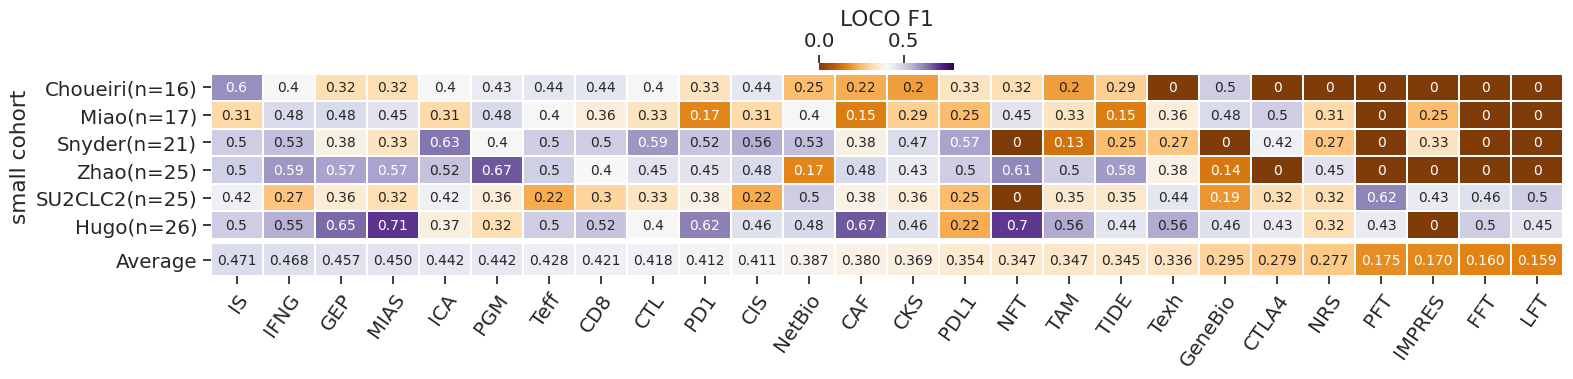

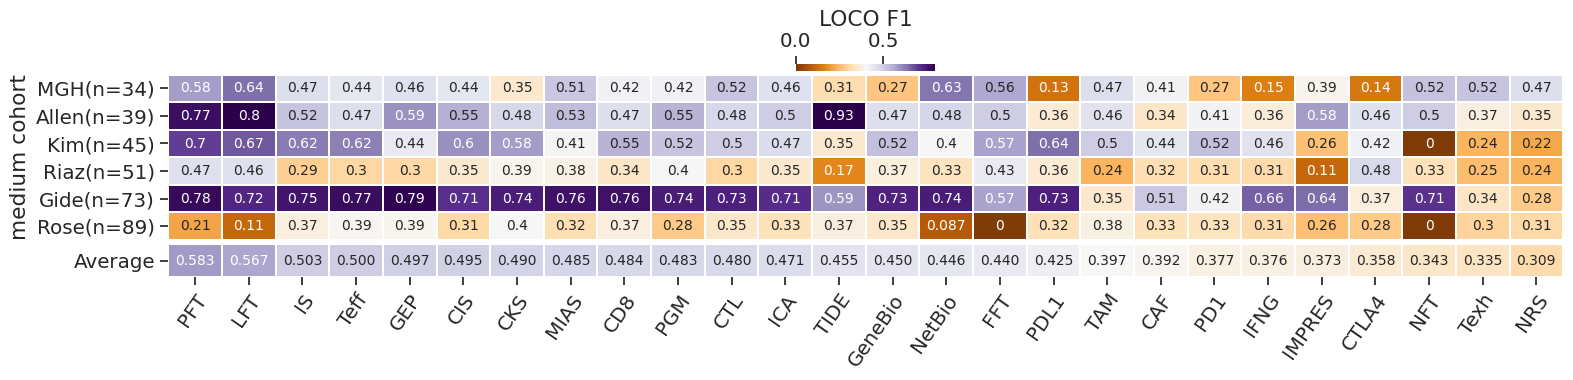

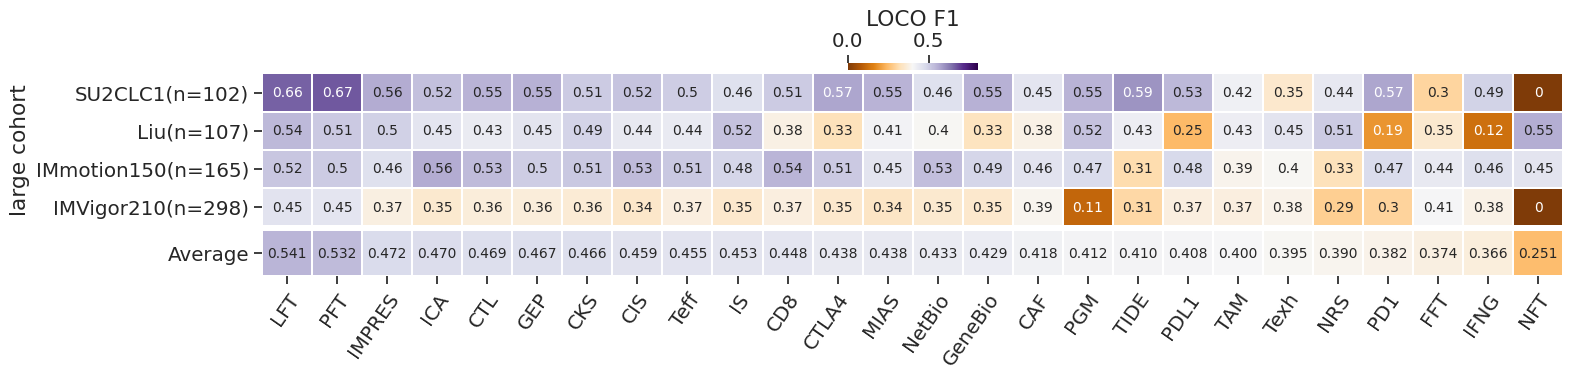

In [38]:
values = 'F1'
    
cmap = 'PuOr' #PRGn PuOr
vmax = 0.8
vmin = 0.0

for s in ['small', 'medium', 'large']:

    dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))
    
    y_order = dfp1.sort_values('size')['cohort_name'].unique()
    data2d = pd.pivot_table(dfp1, index='mode', columns = 'cohort_name', values = values)
    modes = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    data2d = data2d[y_order]
    data2d = data2d.loc[modes].T

    fig,axes = plt.subplots(figsize=(16, 4), nrows=2, height_ratios = [len(y_order), 1], sharex=True)
    ax1, ax2 = axes  

    cbar_kws=dict(location="top",pad=0.02,shrink=0.1, label = 'LOCO %s' % values)
    sns.heatmap(data2d, cmap = cmap, vmax = vmax, vmin = vmin, ax=ax1, cbar_kws = cbar_kws,
                    linewidths = 0.1, annot=True, annot_kws = {'fontsize':10})
    
    
    sns.heatmap(data2d.mean().to_frame(name='Average').T, 
                
                cmap = cmap, vmax = vmax, vmin = vmin,
                ax=ax2, annot=True, linewidths=.1,fmt='.3f',
                 annot_kws={"fontsize":10}, cbar=False)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('%s cohort' % s)
        
    ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax2.set_xticklabels(
        modes, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke
    
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)
    ax2.set_xlabel('')
    
    fig.tight_layout(h_pad = 0.2)
    fig.savefig('./%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi=96 )

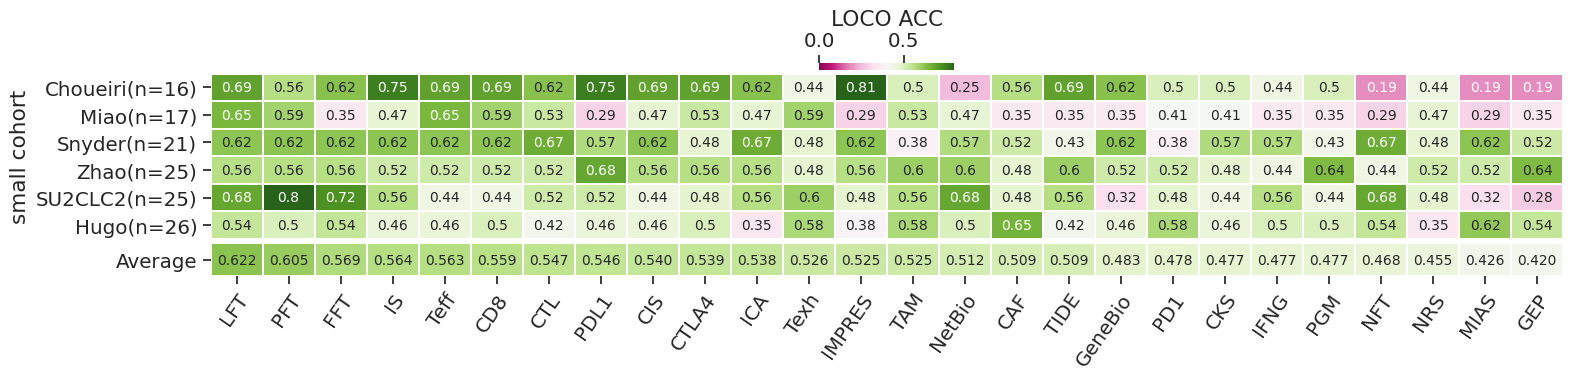

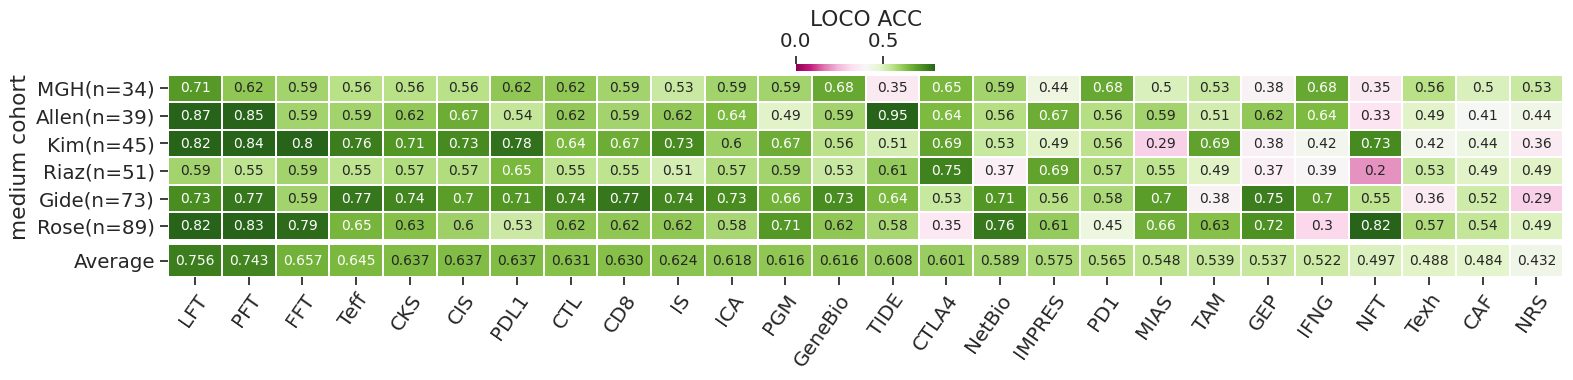

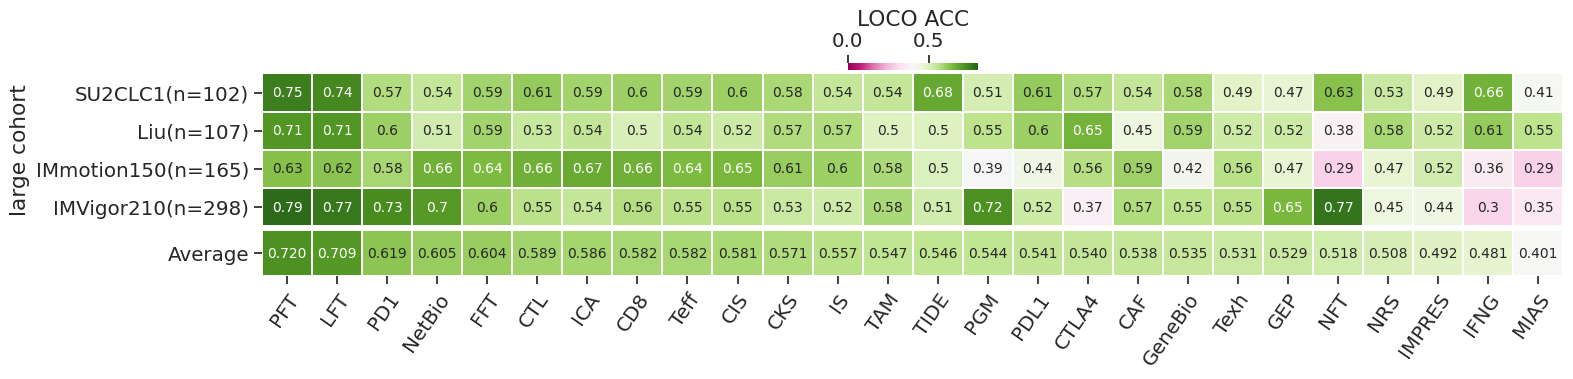

In [39]:
values = 'ACC'
    
cmap = 'PiYG' #PRGn PuOr
vmax = 0.8
vmin = 0.0

for s in ['small', 'medium', 'large']:

    dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))
    
    y_order = dfp1.sort_values('size')['cohort_name'].unique()
    data2d = pd.pivot_table(dfp1, index='mode', columns = 'cohort_name', values = values)
    modes = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    data2d = data2d[y_order]
    data2d = data2d.loc[modes].T

    
    fig,axes = plt.subplots(figsize=(16, 4), nrows=2, height_ratios = [len(y_order), 1], sharex=True)
    ax1, ax2 = axes  

    cbar_kws=dict(location="top",pad=0.02,shrink=0.1, label = 'LOCO %s' % values)
    sns.heatmap(data2d, cmap = cmap, vmax = vmax, vmin = vmin, ax=ax1, cbar_kws = cbar_kws,
                    linewidths = 0.1, annot=True, annot_kws = {'fontsize':10})
    
    
    sns.heatmap(data2d.mean().to_frame(name='Average').T, 
                cmap = cmap, vmax = vmax, vmin = vmin,
                ax=ax2, annot=True, linewidths=.1,fmt='.3f',
                 annot_kws={"fontsize":10}, cbar=False)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('%s cohort' % s)
        
    ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax2.set_xticklabels(
        modes, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke
    
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)
    ax2.set_xlabel('')
    
    fig.tight_layout(h_pad = 0.2)
    fig.savefig('./%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi=96 )

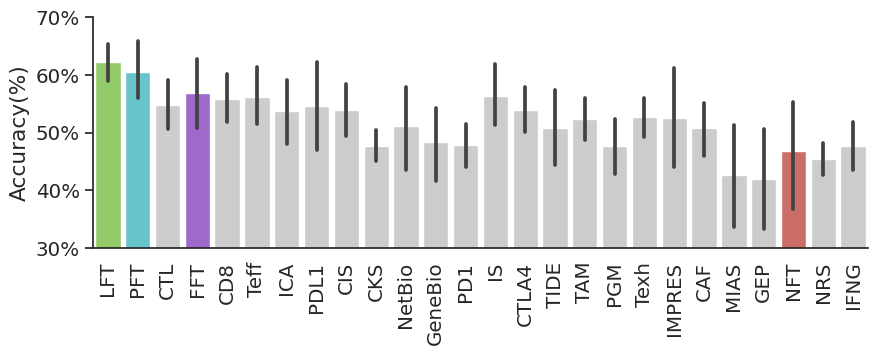

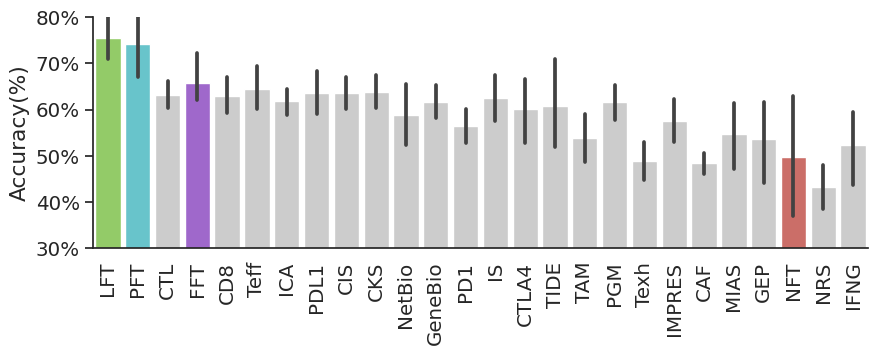

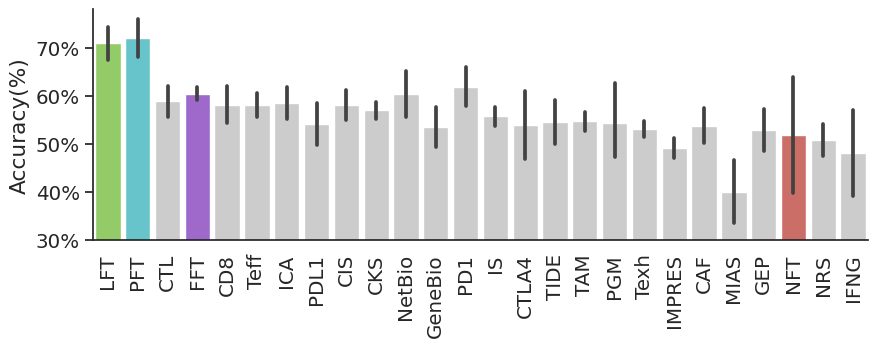

In [40]:
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

values = 'ACC'
order = dfp.groupby('mode')[values].median().sort_values(ascending=False).index.to_list()

for s, ylim in zip(['small', 'medium', 'large'], [(0.3, 0.70), (0.3, 0.80), (0.3, 0.78)]):

    dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))

    fig,ax = plt.subplots(figsize=(10, 3), nrows=1, )
    # order = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    sns.barplot(data = dfp1, x='mode', y = values, order = order,width = 0.85, 
                errorbar = ('ci',80), ax=ax, palette=mode_palette)
    #sns.swarmplot(data = dfp1, x='mode', y =values, order = order,ax=ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Accuracy(%)')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
    ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
    order, 
    rotation=90)  # <====== HERE is the ke

    ax.set_xlabel('')
    #fig.savefig('./bar_%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )

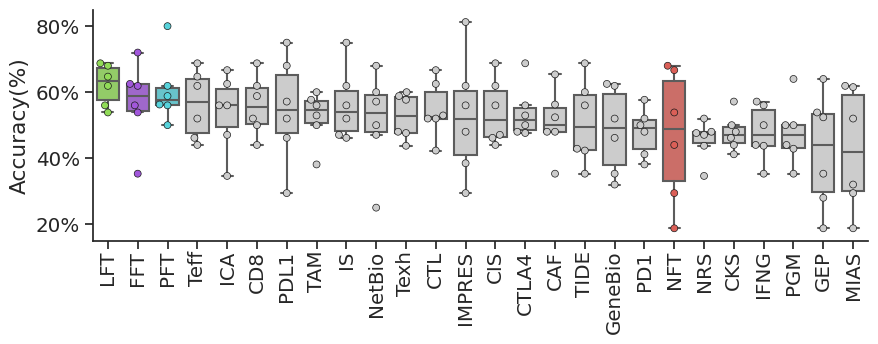

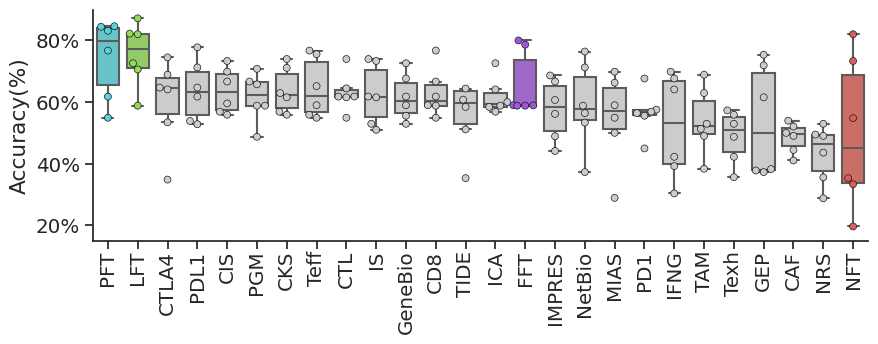

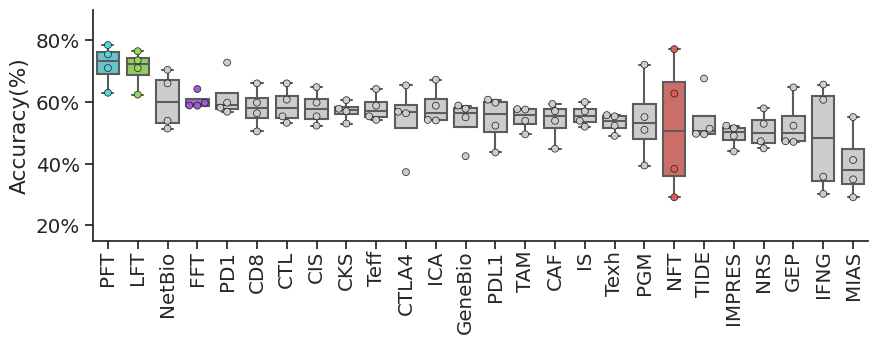

In [41]:
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

values = 'ACC'
for s, ylim in zip(['small', 'medium', 'large'], [(0.15, 0.85), (0.15, 0.9), (0.15, 0.9)]):

    dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))

    order = dfp1.groupby('mode')[values].median().sort_values(ascending=False).index.to_list()

    
    fig,ax = plt.subplots(figsize=(10, 3), nrows=1, )
    
    sns.boxplot(data = dfp1, x='mode', y = values, order = order,width = 0.75, fliersize = 0,
                 ax=ax, palette=mode_palette) #errorbar = ('ci',80),
    
    sns.swarmplot(data = dfp1, x='mode', y = values, order = order, ax=ax,
                  palette=mode_palette, edgecolor='k', linewidth = 0.5 ) #palette=mode_palette
    
    #sns.swarmplot(data = dfp1, x='mode', y =values, order = order,ax=ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Accuracy(%)')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
    order, 
    rotation=90)  # <====== HERE is the ke
    
    ax.tick_params(axis='x', which='major', pad=1)
    
    ax.set_xlabel('')
    fig.savefig('./box_%s_%s.svg' % (values, s), bbox_inches = 'tight', dpi= 96 )
    fig.savefig('./box_%s_%s.svg' % (values, s), bbox_inches = 'tight', dpi= 96 )

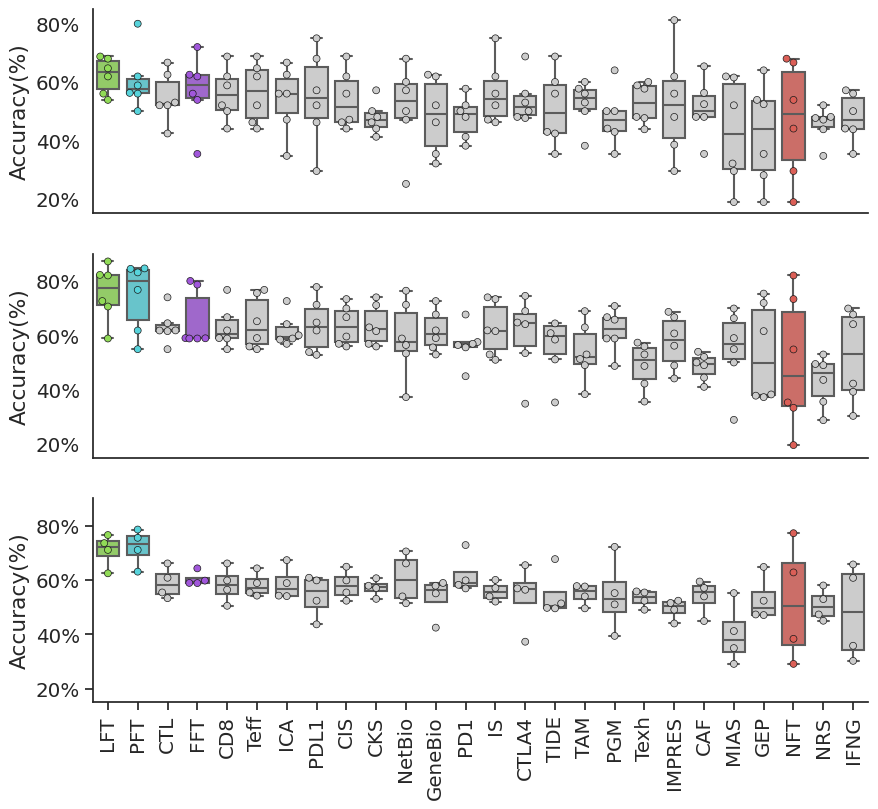

In [42]:
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()
order = dfp.groupby('mode')[values].median().sort_values(ascending=False).index.to_list()


fig,axes = plt.subplots(figsize=(10, 3*3), nrows=3,sharex=True )

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

values = 'ACC'
for s, ylim, ax in zip(['small', 'medium', 'large'], [(0.15, 0.85), (0.15, 0.9), (0.15, 0.9)], axes):

    dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))

    sns.boxplot(data = dfp1, x='mode', y = values, order = order,width = 0.75, fliersize = 0,
                 ax=ax, palette=mode_palette) #errorbar = ('ci',80),
    
    sns.swarmplot(data = dfp1, x='mode', y = values, order = order, ax=ax,
                  palette=mode_palette, edgecolor='k', linewidth = 0.5 ) #palette=mode_palette
    
    #sns.swarmplot(data = dfp1, x='mode', y =values, order = order,ax=ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Accuracy(%)')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])

    if s == 'large':
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
        
        ax.set_xticklabels(
        order, 
        rotation=90)  # <====== HERE is the ke

    ax.set_xlabel('')
    #fig.savefig('./all_box_%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )

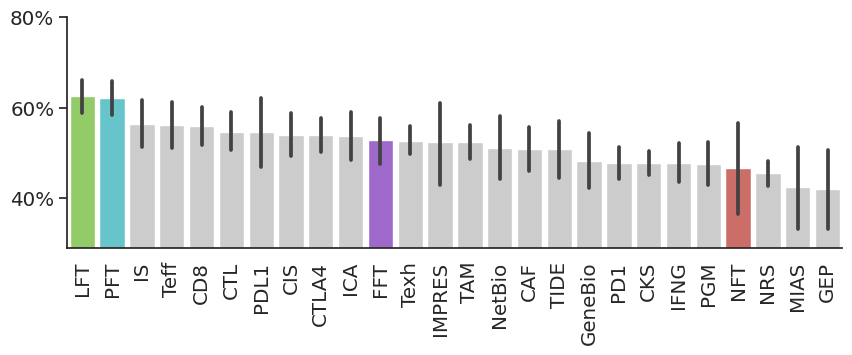

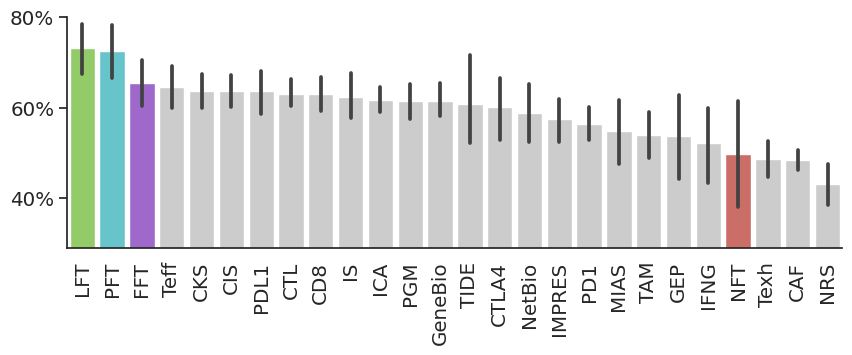

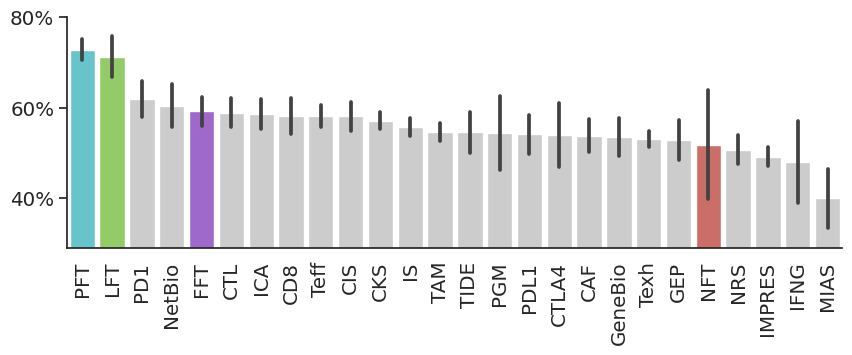

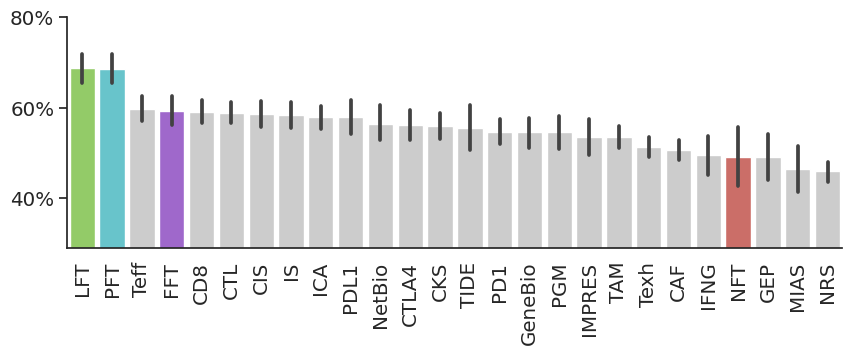

In [17]:
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

values = 'ACC'
for s, ylim in zip(['small', 'medium', 'large', None], [(0.29, 0.80), (0.29, 0.80), (0.29, 0.80), (0.29, 0.80)]):

    if s is None:
        dfp1 = dfp.copy()
    else:
        dfp1 = dfp[dfp['size_map'] == s]
    dfp1['cohort_name'] = dfp1['cohort'].apply(lambda x:x.replace('\n', ''))

    fig,ax = plt.subplots(figsize=(10, 3), nrows=1, )
    order = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    sns.barplot(data = dfp1, x='mode', y = values, order = order,width = 0.85, 
                errorbar = ('ci',80), ax=ax, palette=mode_palette)
    #sns.swarmplot(data = dfp1, x='mode', y =values, order = order,ax=ax)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel(None) #'Accuracy(%)'
    
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]], rotation=180)
    
    ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
    order, 
    rotation=90)  # <====== HERE is the ke

    ax.set_xlabel('')
    #fig.savefig('./bar_%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )

    #fig.savefig('./bar_%s_%s.svg' % (values, s), bbox_inches = 'tight')

